<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_01_imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Testing Class Imbalance

1. **Analyze Class Imbalance**:
    - Check the distribution of classes in your target variable.
    - Visualize the imbalance using bar plots or pie charts.

2. **Implement Sampling Techniques**:
    - **Random Undersampling**: Already included in your pipeline.
    - **Random Oversampling**: Use techniques like SMOTE (Synthetic Minority Over-sampling Technique).
    - **Combination of Over- and Undersampling**: Apply methods like SMOTEENN or SMOTETomek.

3. **Evaluate the Impact of Sampling**:
    - Compare model performance metrics (e.g., F1-score, precision, recall) before and after applying sampling techniques.
    - Use cross-validation to ensure robustness of the results.

4. **Parameter Tuning**:
    - Tune hyperparameters for both the sampling techniques and the model itself.
    - Use GridSearchCV or RandomizedSearchCV to find the optimal parameters.

5. **Experiment with Different Models**:
    - Compare the performance of different classifiers (e.g., RandomForest, SVM, XGBoost) on your dataset.
    - Use ensemble methods to potentially improve performance.



1. **Analyze Class Imbalance**:

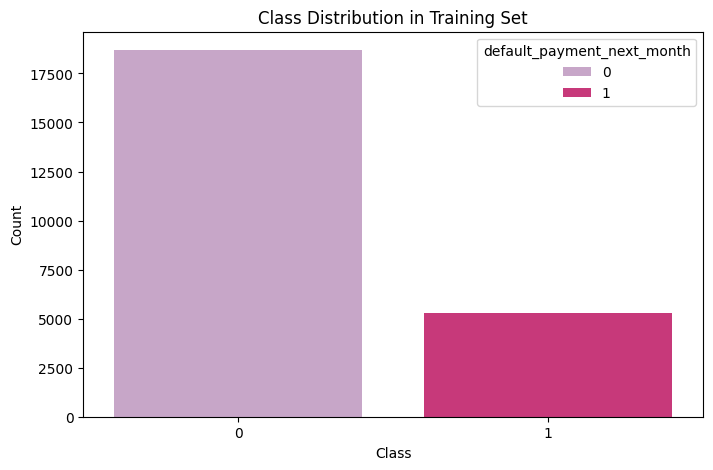

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target=target)

# Plot class balance in the training set
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, hue=y_train, palette='PuRd')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


### 1. Adjusting Class Weights in the Model
You can modify the class weights in the loss function of your neural network. This approach is already somewhat addressed in your code, but you can fine-tune the class weights to see if it improves performance.

### 2. Using Different Thresholds for Classification
Instead of the default threshold of 0.5 for binary classification, you can experiment with different threshold values to find the optimal one that balances precision and recall.

### 3. Resampling Techniques (Undersampling/Oversampling)
You can try undersampling the majority class or oversampling the minority class using techniques like RandomUndersampler or RandomOversampler. This approach is already part of your pipeline, but you can try different sampling strategies.



### Refactor Load and Process Steps

In [2]:
import pandas as pd
import torch
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, define_preprocessor, preprocess_data

def load_and_preprocess_data(url, categorical_columns, target):
    # Load and preprocess data
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)
    X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    return X_train, X_test, y_train, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor


## Experiment with Different Class Weights

In [3]:
import numpy as np
from sklearn.metrics import classification_report, f1_score
from model_pipeline import SklearnSimpleNN, train_model, evaluate_model

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X_train, X_test, y_train, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = load_and_preprocess_data(url, categorical_columns, target)

# Function to evaluate the model with different class weights
def evaluate_class_weights(class_weights):
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    f1 = f1_score(y_test_tensor.numpy(), y_pred)
    return f1

# Generate a range of class weights to test
class_weight_range = np.linspace(0.5, 5.0, 10)
best_f1 = 0
best_weights = None

for weight in class_weight_range:
    class_weights = [1.0, weight]
    f1 = evaluate_class_weights(class_weights)
    print(f"Class weights: {class_weights}, F1-score: {f1}")
    if f1 > best_f1:
        best_f1 = f1
        best_weights = class_weights

print(f"Best class weights: {best_weights}, Best F1-score: {best_f1}")

# Train and evaluate the model with the best class weights
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_weights[1])
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

Class weights: [1.0, 0.5], F1-score: 0.31365533691115083
Class weights: [1.0, 1.0], F1-score: 0.44708209693372897
Class weights: [1.0, 1.5], F1-score: 0.501323918799647
Class weights: [1.0, 2.0], F1-score: 0.5222222222222223
Class weights: [1.0, 2.5], F1-score: 0.5317664340800587
Class weights: [1.0, 3.0], F1-score: 0.5268542199488491
Class weights: [1.0, 3.5], F1-score: 0.5253395163961577
Class weights: [1.0, 4.0], F1-score: 0.5158705701078582
Class weights: [1.0, 4.5], F1-score: 0.5259600614439324
Class weights: [1.0, 5.0], F1-score: 0.49588968443383713
Best class weights: [1.0, 2.5], Best F1-score: 0.5317664340800587
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87      4673
         1.0       0.53      0.54      0.53      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.70      0.70      6000
weighted avg       0.79      0.79      0.79      6000



In [4]:
print(best_weights)

[1.0, 2.5]


### Testing Different Thresholds

Threshold: 0.10, F1-score: 0.5352, Precision: 0.5295, Recall: 0.5411
Threshold: 0.20, F1-score: 0.5296, Precision: 0.5372, Recall: 0.5222
Threshold: 0.30, F1-score: 0.5225, Precision: 0.5495, Recall: 0.4981
Threshold: 0.40, F1-score: 0.5161, Precision: 0.5633, Recall: 0.4763
Threshold: 0.50, F1-score: 0.5104, Precision: 0.5808, Recall: 0.4552
Threshold: 0.60, F1-score: 0.5087, Precision: 0.5998, Recall: 0.4416
Threshold: 0.70, F1-score: 0.4949, Precision: 0.6090, Recall: 0.4167
Threshold: 0.80, F1-score: 0.4881, Precision: 0.6254, Recall: 0.4002


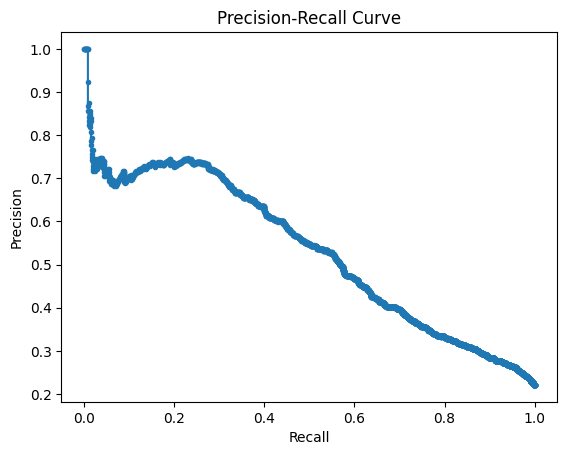

In [6]:
# import numpy as np
# import torch
# from sklearn.metrics import classification_report, precision_recall_curve, f1_score, precision_score, recall_score
# from model_pipeline import load_and_preprocess_data, SklearnSimpleNN, train_model

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X_train, X_test, y_train, y_test, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = load_and_preprocess_data(url, categorical_columns, target)

# Best class weights obtained from previous evaluation
best_weights = best_weights

# Train the model with the best class weights
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_weights[1])
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

# Predict probabilities on the test set
y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

# Function to evaluate model performance at different thresholds
def evaluate_thresholds(y_prob, y_test_tensor, thresholds):
    results = []
    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        f1 = f1_score(y_test_tensor.numpy(), y_pred)
        precision = precision_score(y_test_tensor.numpy(), y_pred)
        recall = recall_score(y_test_tensor.numpy(), y_pred)
        results.append((threshold, f1, precision, recall))
        print(f"Threshold: {threshold:.2f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    return results

# Define a range of thresholds to evaluate
thresholds = np.arange(0.1, 0.9, 0.1)

# Evaluate and print the results for each threshold
results = evaluate_thresholds(y_prob, y_test_tensor, thresholds)

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_tensor.numpy(), y_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

To interpret the precision-recall data and the plot, let's break down the metrics and what they signify:

### Metrics Explanation

1. **Threshold**:
    - This is the decision threshold for classifying a positive instance. For example, a threshold of 0.10 means that if the predicted probability is greater than 0.10, the instance is classified as positive.

2. **F1-Score**:
    - The F1-score is the harmonic mean of precision and recall. It balances the trade-off between precision and recall, providing a single metric that captures both.

3. **Precision**:
    - Precision (or positive predictive value) is the ratio of true positive predictions to the total number of positive predictions. High precision indicates that the model is making fewer false positive errors.

4. **Recall**:
    - Recall (or sensitivity) is the ratio of true positive predictions to the total number of actual positives. High recall indicates that the model is capturing most of the positive instances.

### Interpretation of the Data

#### Precision-Recall Trade-Off

- As you increase the threshold:
    - **Precision tends to increase**: This is because the model becomes more conservative, classifying fewer instances as positive, thus reducing false positives.
    - **Recall tends to decrease**: The model is less likely to classify instances as positive, increasing the chance of false negatives.

- At a lower threshold (e.g., 0.10):
    - The model is more lenient in classifying instances as positive, leading to higher recall but lower precision.
    - This means the model captures more true positives but also includes more false positives.

- At a higher threshold (e.g., 0.80):
    - The model is more stringent, leading to higher precision but lower recall.
    - This means the model is more accurate in its positive predictions but misses more true positives.

### Plot Interpretation

#### Precision-Recall Curve

- The Precision-Recall curve is a plot of precision (y-axis) against recall (x-axis) at various threshold settings.
    - **A good model** will have a curve that bows towards the top right corner, indicating high precision and high recall.

#### Your Plot

- The curve helps visualize the trade-off between precision and recall.
- By examining the curve, you can choose a threshold that balances the two metrics according to your application's needs.

### Choosing the Optimal Threshold

- **Context-Dependent**: The optimal threshold depends on the specific context and goals of your application.
    - If false positives are costly, you might prefer a higher threshold to increase precision.
    - If false negatives are more critical, you might choose a lower threshold to increase recall.

### Example Decision

- In your data:
    - At a threshold of 0.10, you have an F1-score of 0.5352, precision of 0.5295, and recall of 0.5411.
    - At a threshold of 0.50, the F1-score is 0.5104, precision is 0.5808, and recall is 0.4552.
    - If you prioritize recall, a lower threshold like 0.10 might be more suitable.
    - If you prioritize precision, a higher threshold like 0.50 or 0.60 might be better.

### Summary

- Use the precision-recall curve to visualize and decide on the optimal threshold.
- Choose the threshold that best balances precision and recall according to your application's requirements.
- The F1-score can guide you to find a balanced point, but the final decision should consider the specific costs and benefits of precision and recall in your context.

Would you like to implement this analysis or need further assistance with any specific part?